In [6]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error as MAE, mean_absolute_percentage_error as MAPE
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import xgboost as xgb
import holidays  # For Canadian holiday detection

class RedemptionModel:
    def __init__(self, X, target_col):
        self.X = X.copy()
        self.target_col = target_col
        self.results = {}

        # Feature list used in the model
        self.features = [
            'dayofweek', 'dayofyear', 'month', 'is_weekend', 'is_holiday',
            'lag_1', 'lag_7', 'lag_14',
            'rolling_mean_3', 'rolling_mean_7', 'rolling_std_7',
            'diff_1', 'diff_7'
        ]
    # New method: add new features
    def _add_features(self, df):
        df = df.copy()

        # Calendar features
        df['dayofweek'] = df.index.dayofweek # Day of week
        df['dayofyear'] = df.index.dayofyear # Seasonality
        df['month'] = df.index.month # Month of year
        df['is_weekend'] = (df.index.dayofweek >= 5).astype(int) # Weekend

        # Ontario holidays (Canada)
        ca_on = holidays.CountryHoliday('CA', prov='ON')
        df['is_holiday'] = df.index.to_series().apply(lambda d: int(d in ca_on))

        # Lag features
        for lag in [1, 7, 14]:
            df[f'lag_{lag}'] = df[self.target_col].shift(lag)

        # Rolling means and standard deviation (shifted to prevent leakage)
        df['rolling_mean_3'] = df[self.target_col].shift(1).rolling(3).mean()
        df['rolling_mean_7'] = df[self.target_col].shift(1).rolling(7).mean()
        df['rolling_std_7'] = df[self.target_col].shift(1).rolling(7).std()

        # Differences (change in value from previous days)
        df['diff_1'] = df[self.target_col].diff(1)
        df['diff_7'] = df[self.target_col].diff(7)

        return df

    def run_models(self, n_splits=4, test_size=365):
        tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
        cnt = 0
        for train_idx, test_idx in tscv.split(self.X):
            X_train = self.X.iloc[train_idx]
            X_test = self.X.iloc[test_idx]
            y_test = X_test[self.target_col]

            # --- Base model ---
            preds_base = self._base_model(X_train, X_test)
            self._store_results('Base', cnt, y_test, preds_base)
            self.plot(y_test, preds_base, f'Base Split {cnt}')

            # --- XGBoost model ---
            preds_xgb = self._xgb_model(X_train, X_test)
            self._store_results('XGBoost', cnt, y_test, preds_xgb)
            self.plot(y_test, preds_xgb, f'XGBoost Split {cnt}')

            cnt += 1

    def _store_results(self, model_name, split, y_true, y_pred):
        y_true, y_pred = y_true.align(y_pred, join='inner')
        mae = MAE(y_true, y_pred)

        # Exclude zeros for MAPE calculation
        y_true_nonzero = y_true[y_true != 0]
        y_pred_nonzero = y_pred[y_true != 0]
        mape = MAPE(y_true_nonzero, y_pred_nonzero) if len(y_true_nonzero) > 0 else np.nan

        self.results.setdefault(model_name, {})[split] = {'MAE': mae, 'MAPE': mape}

    def _base_model(self, train, test):
        # Your original base model unchanged
        res = sm.tsa.seasonal_decompose(train[self.target_col], period=365)
        res_clip = res.seasonal.apply(lambda x: max(0, x))  # Clip to remove negatives
        res_clip.index = res_clip.index.dayofyear
        res_clip = res_clip.groupby(res_clip.index).mean()
        res_dict = res_clip.to_dict()
        return pd.Series(index=test.index, 
                         data=map(lambda x: res_dict[x], test.index.dayofyear))
        
    # My redemption model using xgb and target has been log-transformed
    def _xgb_model(self, train, test):
        train_feat = self._add_features(train).dropna()
        test_feat = self._add_features(test).dropna(subset=self.features)

        # Define input/output for XGBoost
        X_train = train_feat[self.features]
        y_train = np.log1p(train_feat[self.target_col])  # log-transformed target
        X_test = test_feat[self.features]

        # Train model
        model = xgb.XGBRegressor(
            n_estimators=100, max_depth=4, learning_rate=0.1, objective='reg:squarederror'
        )
        model.fit(X_train, y_train)

        # Predict and inverse log transform
        preds = np.expm1(model.predict(X_test))
        return pd.Series(preds, index=X_test.index)
        
    # Plot only test data (improved over original full-data plot)
    def plot(self, truth, preds, label):
        # Plot actual vs predicted
        plt.figure(figsize=(15, 5))
        plt.plot(truth.index, truth, label='Observed (Test)', color='grey', linewidth=1)
        plt.plot(preds.index, preds, label='Predicted', linewidth=2)
        plt.title(f'Forecast vs Observed - {label} (Test Period Only)')
        plt.legend()
        plt.tight_layout()
        plt.show()


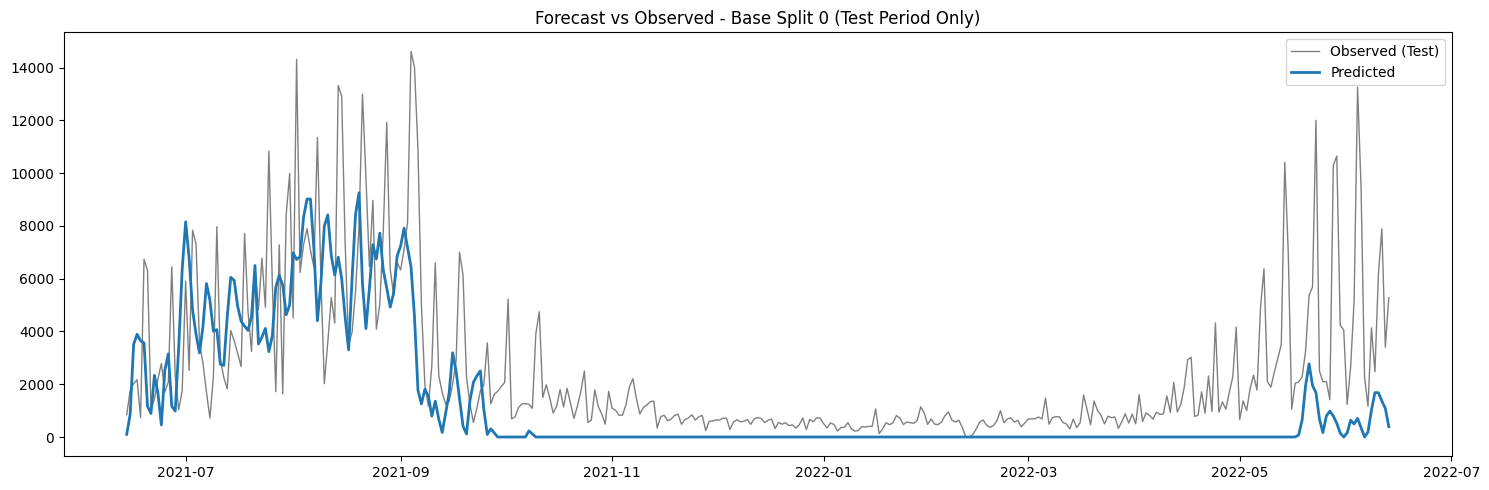

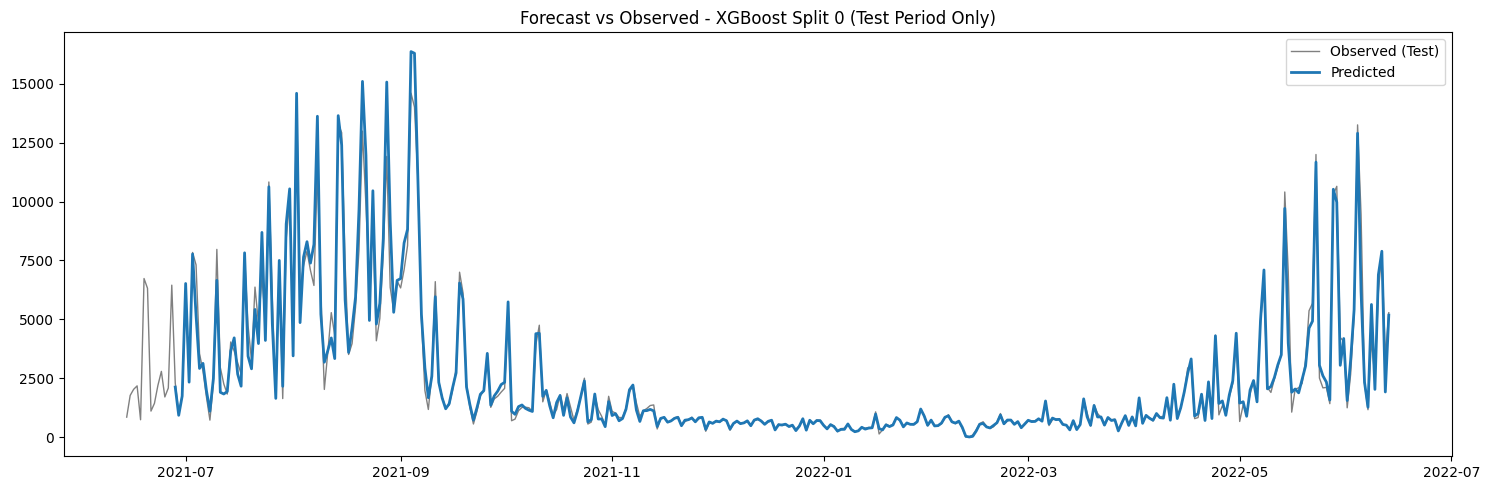

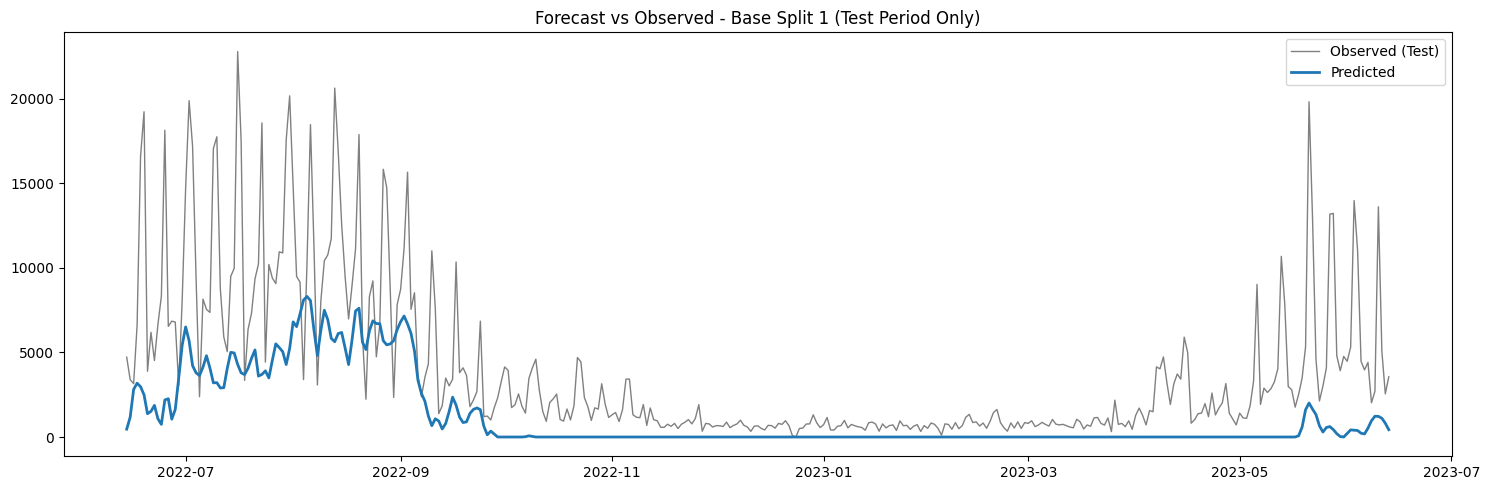

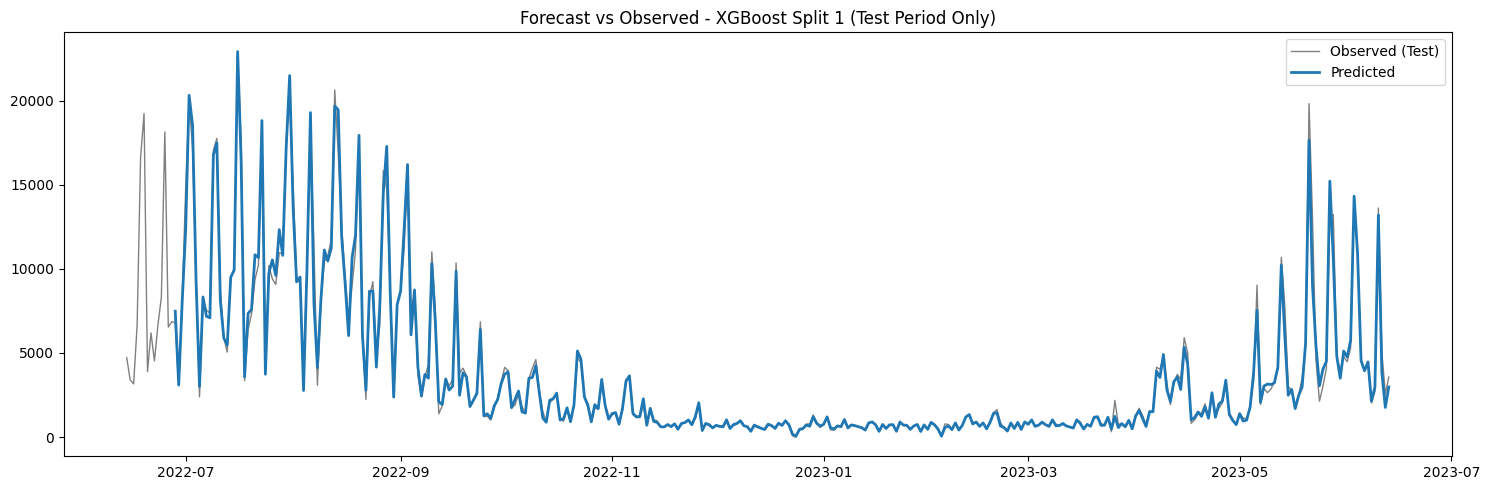

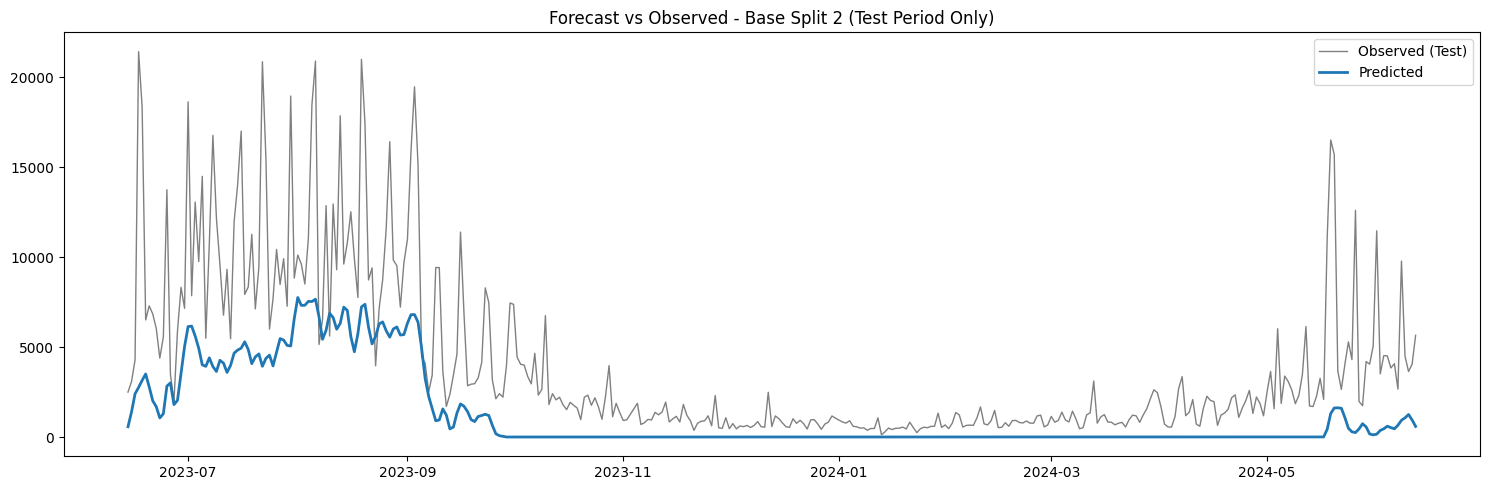

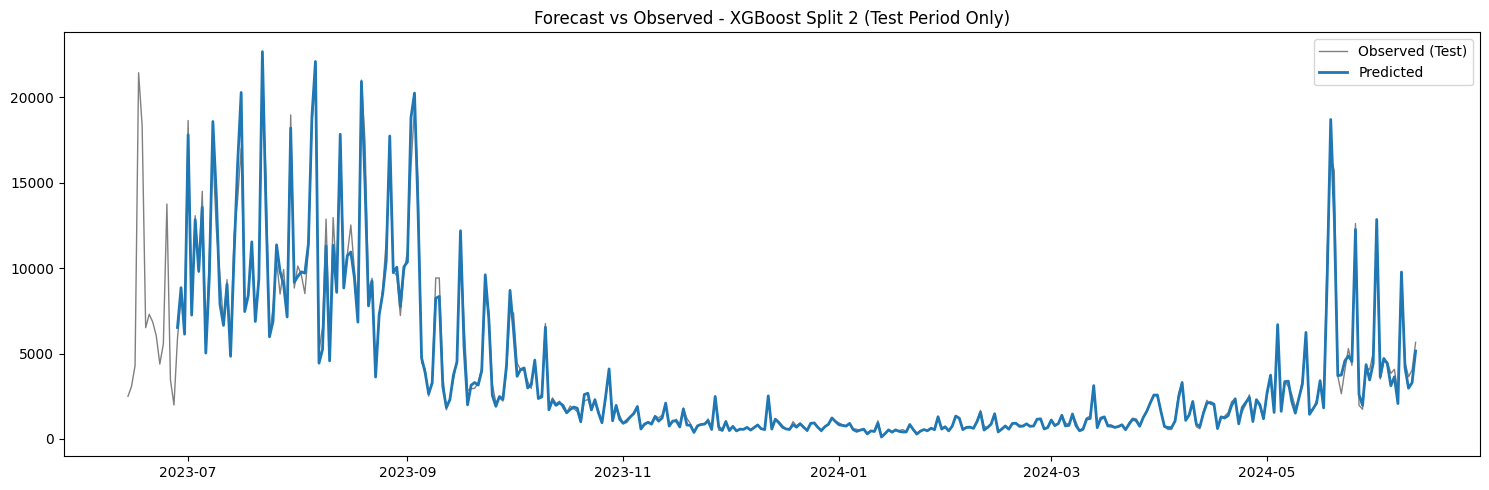

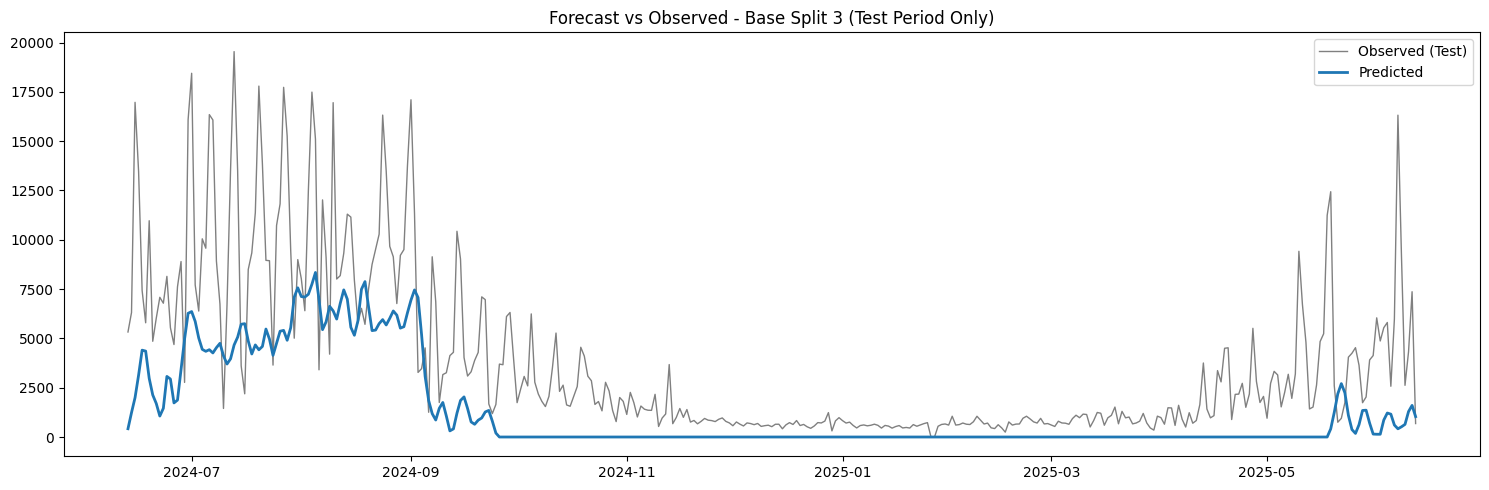

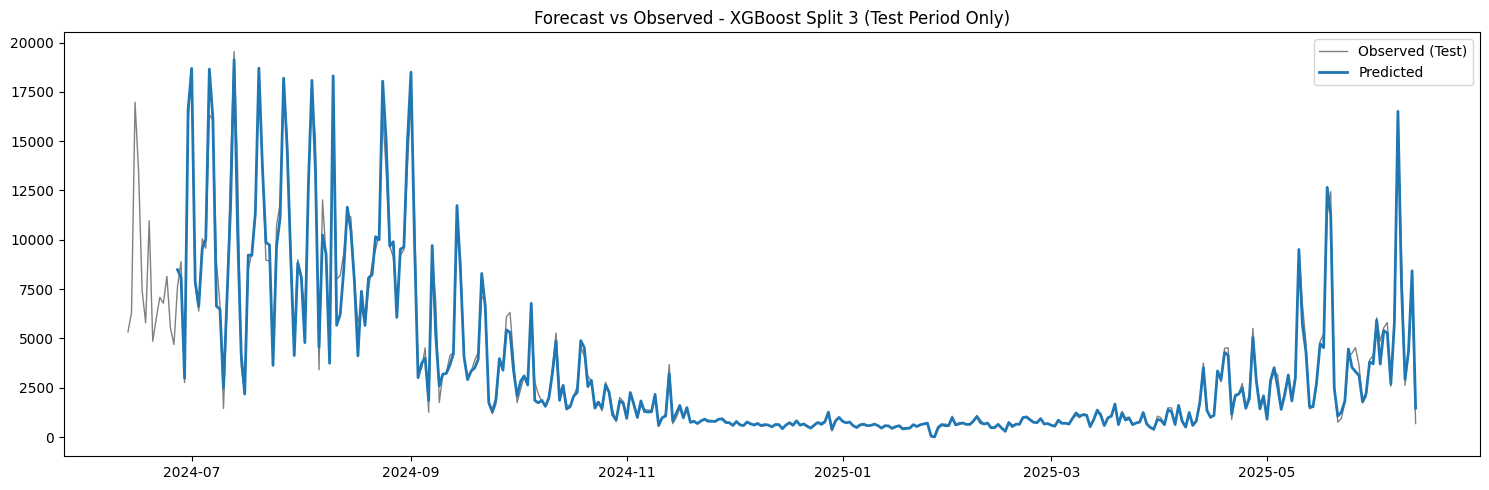

{'Base': {0: {'MAE': 1738.937433739669, 'MAPE': 0.8967144717346455}, 1: {'MAE': 2809.26075766965, 'MAPE': 0.855820447965577}, 2: {'MAE': 2768.5040472466194, 'MAPE': 0.8496394658197937}, 3: {'MAE': 2621.065679566855, 'MAPE': 0.8623453613071664}}, 'XGBoost': {0: {'MAE': 287.72430419921875, 'MAPE': 0.10888879746198654}, 1: {'MAE': 288.41583251953125, 'MAPE': 0.0822078064084053}, 2: {'MAE': 313.7651672363281, 'MAPE': 0.0785662904381752}, 3: {'MAE': 287.78704833984375, 'MAPE': 0.07779336720705032}}}

Average Errors Across Splits:
Base: MAE = 2484.4, MAPE = 86.6%
XGBoost: MAE = 294.4, MAPE = 8.7%


In [7]:
import pandas as pd
# from RedemptionModel import RedemptionModel  # If your class is in a separate file (optional)

# --- Step 1: Load and preprocess data ---
def load_data(file_path):
    df = pd.read_csv(file_path,
                     dtype={'_id': int, 'Redemption Count': int, 'Sales Count': int},
                     parse_dates=['Timestamp'])
    
    # Sort by date and set index
    df.sort_values('Timestamp', inplace=True)
    df.set_index('Timestamp', inplace=True)

    # Resample to daily frequency
    df_daily = df.resample('D').sum()

    return df_daily

# --- Step 2: Run the model ---
if __name__ == "__main__":
    # Load data
    file_path = './Toronto Island Ferry Ticket Counts.csv' 
    df_daily = load_data(file_path)

    # Initialize and run model
    model = RedemptionModel(df_daily, target_col='Redemption Count')
    model.run_models()
    print(model.results)

    # --- Step 3: Print results ---
    print("\nAverage Errors Across Splits:")
    for model_name in model.results:
        maes = [result['MAE'] for result in model.results[model_name].values()]
        mapes = [result['MAPE'] * 100 for result in model.results[model_name].values()]
        print(f"{model_name}: MAE = {sum(maes)/len(maes):.1f}, MAPE = {sum(mapes)/len(mapes):.1f}%")
